# Memory task initial data exploration
## Matt Oberhardt



### Imports & API calls:

In [283]:
import synapseclient
from synapseclient import Project, Folder, File
import pandas as pd
import json
import pickle
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
import seaborn as sns
import os
from numpy import nan
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import ranksums
%load_ext autoreload
%matplotlib inline  
# from pandas import DataFrame, Series
np.set_printoptions(threshold='nan') # so that i can print as many lines as i want

sns.set(font_scale=1.5)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import memorytools as mt

### Load up the memory & demographic data:

In [3]:
# initialize environment:
synuser = os.environ['SYNAPSE_USER']
synpass = os.environ['SYNAPSE_PASS']
mt.loadSynapseRecordsFromScratch = False
syn, memory, memorysyn, filePaths, demographics, demosyn, data = mt.create_memory_environment(synuser, synpass)
data = mt.filter_data_for_popular_phones(data)


Welcome, Matthew Oberhardt!
(phones are now filtered for only the most popular ones)


In [4]:
# pull out features from games:
fromFile = True#False
toSave = False#True
data = mt.add_memory_game_features_to_data(filePaths, data, fromFile = fromFile, toSave=toSave, outFileName='memory_data_with_features.p')

memory features loaded from file: memory_data_with_features.p (input data was ignored)


In [5]:
# add memory composite features:
data = mt.add_composite_features_to_data(data)

### Visualize the memory data:

#### Columns:

In [6]:
# columns:
for col in data.columns:
    print col

recordId
healthCode
createdOn
appVersion
phoneInfo
game_score
game_numGames
game_numFails
game_startDate
game_endDate
game_records
medTimepoint
game_records_txt
recordId_demographic
createdOn_demographic
appVersion_demographic
phoneInfo_demographic
age
isCaretaker
brainStim
diagYear
education
employment
gender
healthHistory
healthcareProvider
homeUsage
lastSmoked
maritalStatus
medicalUsage
medicalUsageYesterday
medicationStartYear
onsetYear
packsPerDay
pastParticipation
phoneUsage
professionalDiagnosis
race
smartphone
smoked
surgery
videoUsage
yearsSmoking
gamesdata
16_latency
16_gamescore
16_successful
16_meanDt
16_meandist
16_gamesize
16_meanunsuccessfuldist
16_meansuccessfuldist
16_numunsuccesses
16_numsuccesses
16_firstdist
9_latency
9_gamescore
9_successful
9_meanDt
9_meandist
9_gamesize
9_meanunsuccessfuldist
9_meansuccessfuldist
9_numunsuccesses
9_numsuccesses
9_firstdist
4_latency
4_gamescore
4_successful
4_meanDt
4_meandist
4_gamesize
4_meanunsuccessfuldist
4_meansuccessfuldis

In [7]:
# How many nans in each column?
mt.display_num_nulls_per_column(data)



Number of nulls per column:

recordId                      0
played_game4                  0
hasParkinsons                 0
phoneInfo_demographic         0
appVersion_demographic        0
createdOn_demographic         0
recordId_demographic          0
game_records_txt              0
game_records                  0
gamesdata                     0
game_startDate                0
healthCode                    0
game_numFails                 0
game_numGames                 0
game_score                    0
phoneInfo                     0
appVersion                    0
createdOn                     0
game_endDate                  0
9_gamescore                   2
9_successful                  2
9_meandist                    2
9_gamesize                    2
9_numsuccesses                2
9_numunsuccesses              2
9_firstdist                   2
9_latency                     2
medTimepoint                  4
gender                        5
smartphone                    5
9_meanDt   

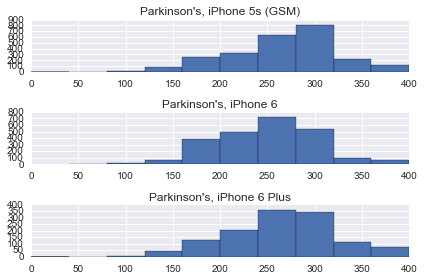

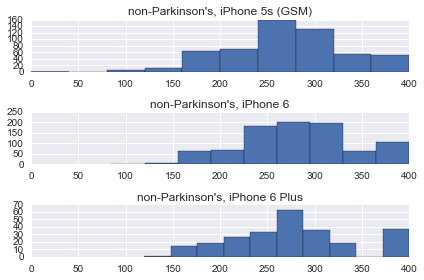

In [8]:
# compare these for parkinson's and non-parkinson's
# do on same plot too

# todo check if the scores are different, within parkinson's category, for phone type!

byphonePark = data[data.hasParkinsons==True].groupby('phoneInfo')
byphonenonPark = data[data.hasParkinsons==False].groupby('phoneInfo')

grouped = byphonePark
plt.figure()
numphones = len(grouped)
allphones = grouped.phoneInfo.unique()
for n, phone in enumerate(allphones):
    plt.subplot(len(allphones),1,n+1)
    data.game_score[grouped.groups[phone[0]]].hist()
    plt.title("Parkinson's, %s" % phone[0])
plt.tight_layout()

grouped = byphonenonPark
plt.figure()
numphones = len(grouped)
allphones = grouped.phoneInfo.unique()
for n, phone in enumerate(allphones):
    a = plt.subplot(len(allphones),1,n+1)
    data.game_score[grouped.groups[phone[0]]].hist()
    plt.title("non-Parkinson's, %s" % phone[0])
    a.set_xlim([0,400])
plt.tight_layout()

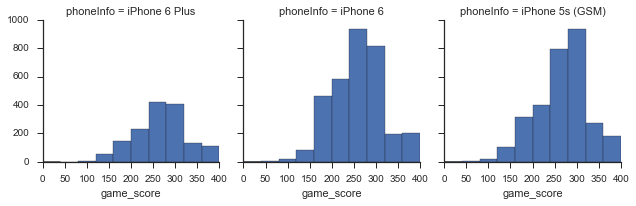

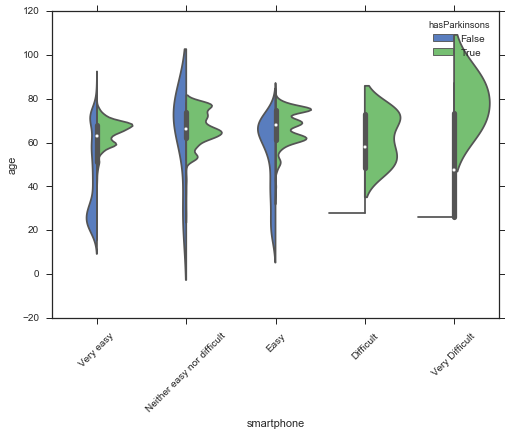

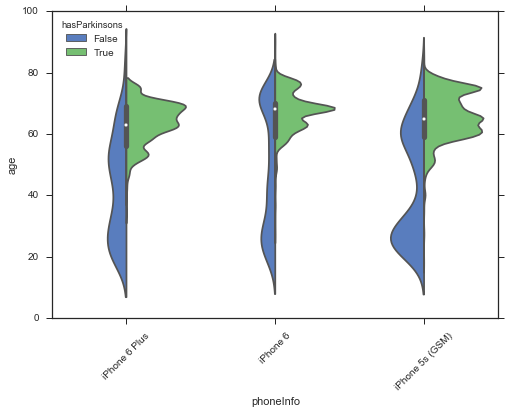

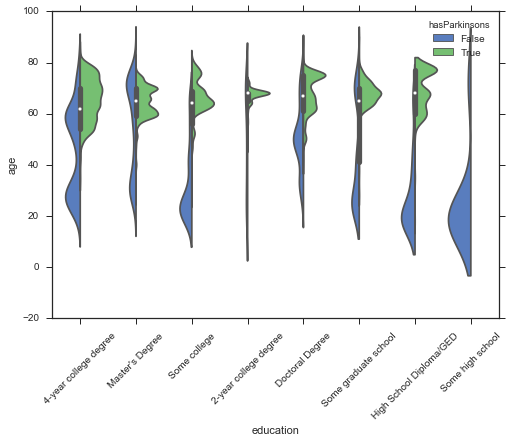

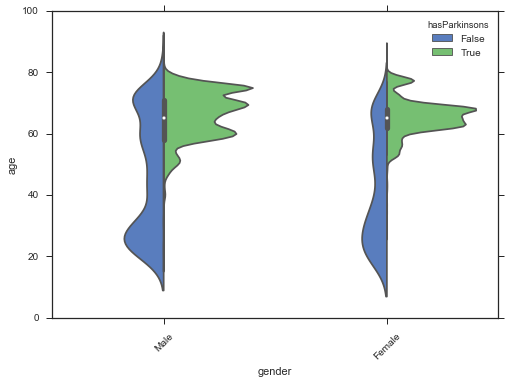

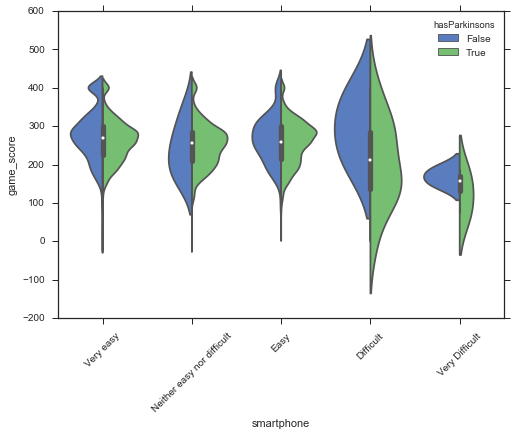

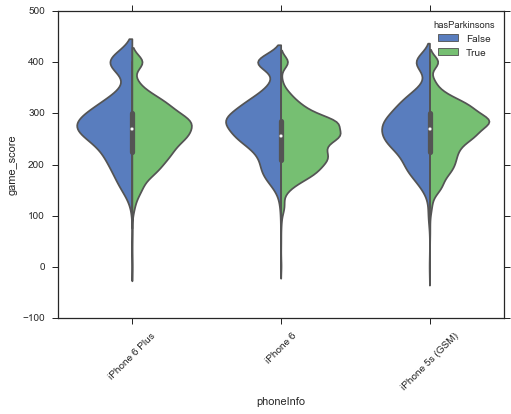

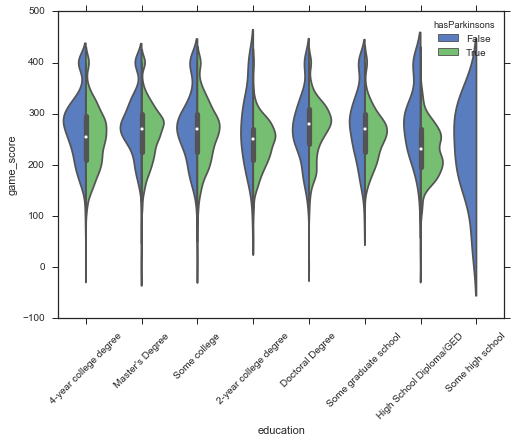

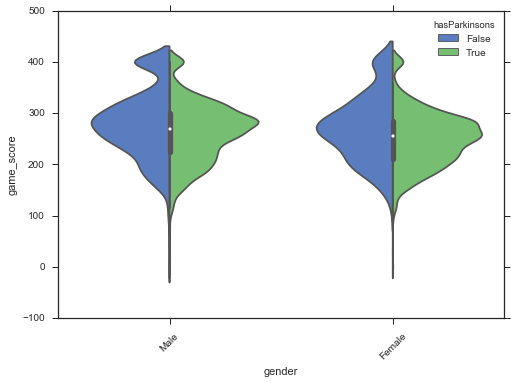

In [9]:
sns.set(style="ticks", color_codes=True)

features_to_check_against_Parkinsons = ["game_score","age",
        "game_numFails", "phoneInfo", "education", "gender", 
        "phoneUsage", "smartphone"]
            
otherfeatures =  ['9_numsuccesses', '9_numunsuccesses',
                '9_gamesize', '9_meandist', '9_successful',
                '9_gamescore', '9_latency', '9_firstdist']
#ax1 = sns.violinplot(x="phoneInfo", y="game_score", hue="hasParkinsons", data=data, palette="muted")#, split=True)    
#ax2 = sns.violinplot( y="game_score", hue="hasParkinsons", data=data, palette="muted", split=True)    

#features_to_check = ['phoneInfo, BLAST']
g = sns.FacetGrid(data, col="phoneInfo")
g = g.map(plt.hist, "game_score")

yvar = 'hasParkinsons'
catvars = ['smartphone', 'phoneInfo', 'education', 'gender']
freqvars = ['age', 'game_score']

for freqvar in freqvars:
    for catvar in catvars:
        plt.figure()
        ax1 = sns.violinplot(x=catvar, y=freqvar, hue=yvar, data=data, palette="muted", split=True)    
        plt.xticks(rotation=45)



Features converted to numbers:

['gender', 'phoneUsage', 'smartphone', 'education', 'phoneInfo']


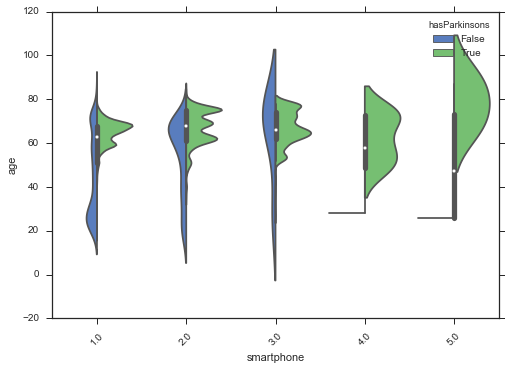

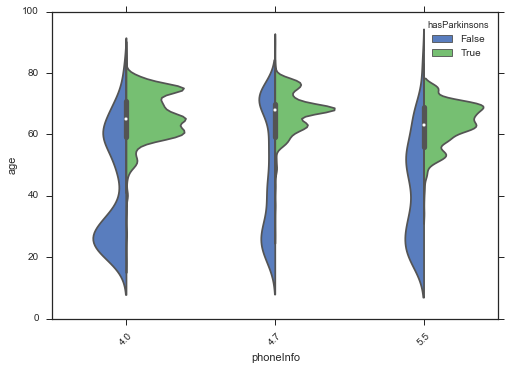

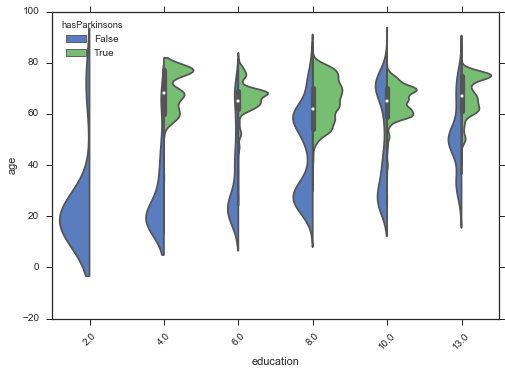

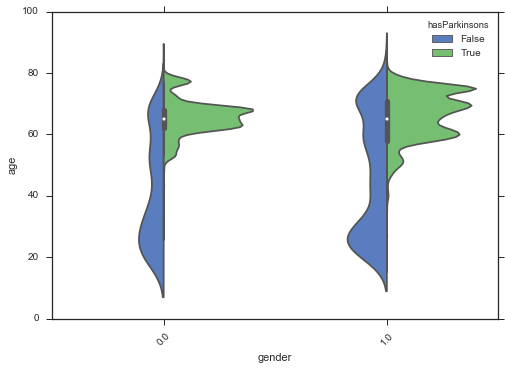

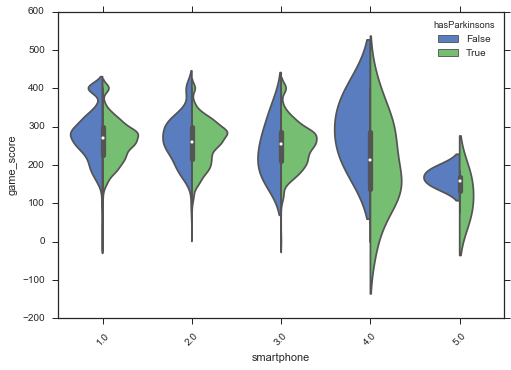

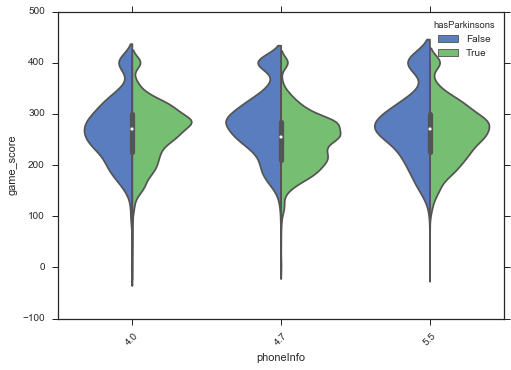

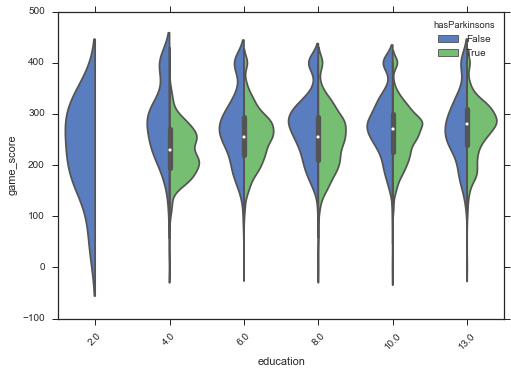

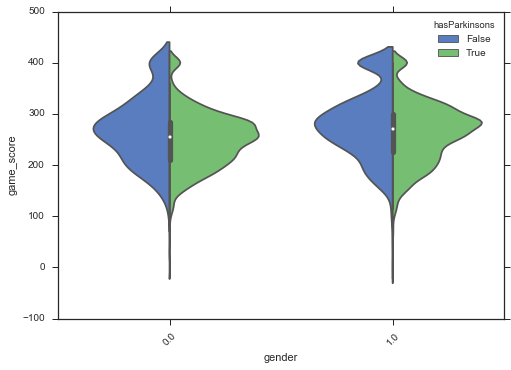

In [10]:
# revisualize after turning categorical-ordered into #'s:
features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]
features_df = data[features]
features_df = mt.convert_features_to_numbers(features_df)

yvar = 'hasParkinsons'
catvars = ['smartphone', 'phoneInfo', 'education', 'gender']
freqvars = ['age', 'game_score']

for freqvar in freqvars:
    for catvar in catvars:
        plt.figure()
        ax1 = sns.violinplot(x=catvar, y=freqvar, hue=yvar, data=features_df, palette="muted", split=True)    
        plt.xticks(rotation=45)

        

## Troubleshoot the features from the game:

In [11]:
#data[['16_meansuccessfuldist','16_meanunsuccessfuldist']]

In [12]:
### look at one record where meansuccessfuldist > meanunsuccessfuldist -- that is wierd (might be a bug)
#rowidx = 7944
#print data['recordId'][rowidx]
#games = data['gamesdata'][rowidx]['games_by_sizes']
#games
##data['recordId'][rowidx]
## problem here... 

In [13]:
#games16 = games[16]
#avg_memory_features = mt.average_features_from_memory_games(games16)
#
##memory_features = mt.pull_features_from_memory_game(game)
##memory_features

#avg_memory_features
### It seems that the MemoryGameTouchSampleIsCorrect field is WRONG here!?, for the 1st result from game 16.

# Machine learning

### Imports & API calls:

In [14]:
from sklearn import linear_model
import sklearn
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.tree
import sklearn.ensemble
import numpy as np
from sklearn.utils.validation import check_consistent_length, _num_samples
import sklearn.preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### Pick & process features, 1st logistic regression:

In [15]:
##### define features:

features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]
features_df = data[features]

features_df = mt.convert_features_to_numbers(features_df)
features_df = mt.move_col_to_end_of_df(features_df, 'hasParkinsons')

# do more processing here, in case of features with lots of nas

# drop na rows:
features_df = features_df.dropna()

# convert to matrices for machine learning:
labelcol = 'hasParkinsons'
X, y, X_names, y_name = mt.convert_features_df_to_X_and_y_for_machinelearning(features_df, labelcol)
    
###### perform logistic regression

# do cross validation manually:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# scale features:
stdsc = StandardScaler()
stdsc.fit(X_train)
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# create logistic regression model:
lr = LogisticRegression(C=1000.0, random_state=0)##
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
lr.fit(X_train_std, y_train)


###### assess regression performance:
lr.coef_
lr.intercept_ # this is the 0 coeff?
lr.fit(X_train_std, y_train)
print 'training accuracy:', lr.score(X_train_std, y_train)
print 'test accuracy:', lr.score(X_test_std, y_test) # suspiciously high..
lr.intercept_
lr.coef_ # only using 4 features.. which ones?
# mt.plot_decision_regions(X_combined_std, y_combined_std, classifier=lr, test_idx=range(len(X_train_std),len(X_combined_std)+1))
X_names_heavy = X_names[np.where(np.abs(lr.coef_) > 0.1)[1]]
Scoef = mt.convert_regression_coefs_to_pdSeries(lr.coef_, X_names)

print '\n'
print Scoef.sort_values()
#print lr.score
# tp / (tp + fn)

# look at sklearn.metrics

pass


Features converted to numbers:

['gender', 'phoneUsage', 'smartphone', 'education', 'phoneInfo']
training accuracy: 0.888564654386
test accuracy: 0.881327094853


phoneUsage      -0.726648
gender          -0.535846
education       -0.091916
game_score       0.030728
game_numFails    0.104056
phoneInfo        0.126661
age              1.523501
smartphone       1.527187
dtype: float64


### Try logistic regression, inputting the hasParkinsons column as a feature
#### (should give perfect prediction)

In [16]:

##### define features:
features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]
features_df = data[features]
features_df['hasParkinsons2'] = data['hasParkinsons']

features_df = mt.convert_features_to_numbers(features_df)
features_df = mt.move_col_to_end_of_df(features_df, 'hasParkinsons')

# do more processing here, in case of features with lots of nas

# drop na rows:
features_df = features_df.dropna()

# convert to matrices for machine learning:
labelcol = 'hasParkinsons'
X, y, X_names, y_name = mt.convert_features_df_to_X_and_y_for_machinelearning(features_df, labelcol)
    
###### perform logistic regression

# do cross validation manually:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# scale features:
stdsc = StandardScaler()
stdsc.fit(X_train)
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# create logistic regression model:
lr = LogisticRegression(C=1000.0, random_state=0)##
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
lr.fit(X_train_std, y_train)


###### assess regression performance:
lr.coef_
lr.intercept_ # this is the 0 coeff?
lr.fit(X_train_std, y_train)
print 'training accuracy:', lr.score(X_train_std, y_train)
print 'test accuracy:', lr.score(X_test_std, y_test) # suspiciously high..
lr.intercept_
lr.coef_ # only using 4 features.. which ones?
# mt.plot_decision_regions(X_combined_std, y_combined_std, classifier=lr, test_idx=range(len(X_train_std),len(X_combined_std)+1))
X_names_heavy = X_names[np.where(np.abs(lr.coef_) > 0.1)[1]]
Scoef = mt.convert_regression_coefs_to_pdSeries(lr.coef_, X_names)

print '\n'
print Scoef.sort_values()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Features converted to numbers:

['gender', 'phoneUsage', 'smartphone', 'education', 'phoneInfo']
training accuracy: 1.0
test accuracy: 1.0


phoneUsage       -0.116390
gender           -0.104257
game_score       -0.069913
education         0.006747
game_numFails     0.077573
phoneInfo         0.096486
smartphone        0.187908
age               0.625051
hasParkinsons2    9.381030
dtype: float64


/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#### that works well. good.

### Add memory features to model, & redo logistic regression

In [17]:
# How many nans in each column?
numnulls = data.isnull().sum()
pd.set_option('display.max_rows', len(numnulls))
numnulls.sort_values(inplace=True, ascending=True)
print 'Number of nulls per column:\n'
print numnulls

Number of nulls per column:

recordId                      0
played_game4                  0
hasParkinsons                 0
phoneInfo_demographic         0
appVersion_demographic        0
createdOn_demographic         0
recordId_demographic          0
game_records_txt              0
game_records                  0
gamesdata                     0
game_startDate                0
healthCode                    0
game_numFails                 0
game_numGames                 0
game_score                    0
phoneInfo                     0
appVersion                    0
createdOn                     0
game_endDate                  0
9_gamescore                   2
9_successful                  2
9_meandist                    2
9_gamesize                    2
9_numsuccesses                2
9_numunsuccesses              2
9_firstdist                   2
9_latency                     2
medTimepoint                  4
gender                        5
smartphone                    5
9_meanDt   

In [18]:
##### define features:
gamefeatures = ['9_numsuccesses', '9_numunsuccesses',
                '9_gamesize', '9_meandist', '9_successful',
                '9_gamescore', '9_latency', '9_firstdist', '9_meanDt']
features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]
features = gamefeatures + features
#features = gamefeatures + ['game_score', 'hasParkinsons']

In [19]:
# transform features, etc.
features_df = data[features]

features_df = mt.convert_features_to_numbers(features_df)
features_df = mt.move_col_to_end_of_df(features_df, 'hasParkinsons')

# do more processing here, in case of features with lots of nas

# drop na rows:
features_df = features_df.dropna()

# convert to matrices for machine learning:
labelcol = 'hasParkinsons'
X, y, X_names, y_name = mt.convert_features_df_to_X_and_y_for_machinelearning(features_df, labelcol)
    
###### perform logistic regression

# do cross validation manually:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# scale features:
stdsc = StandardScaler()
stdsc.fit(X_train)
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# create logistic regression model:
lr = LogisticRegression(C=1000.0, random_state=0)##
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
lr.fit(X_train_std, y_train)


###### assess regression performance:
lr.coef_
lr.intercept_ # this is the 0 coeff?
lr.fit(X_train_std, y_train)
print 'training accuracy:', lr.score(X_train_std, y_train)
print 'test accuracy:', lr.score(X_test_std, y_test) # suspiciously high..
lr.intercept_
lr.coef_ # only using 4 features.. which ones?
# mt.plot_decision_regions(X_combined_std, y_combined_std, classifier=lr, test_idx=range(len(X_train_std),len(X_combined_std)+1))
X_names_heavy = X_names[np.where(np.abs(lr.coef_) > 0.1)[1]]
Scoef = mt.convert_regression_coefs_to_pdSeries(lr.coef_, X_names)

print '\n'
print Scoef.sort_values()

Features converted to numbers:

['gender', 'phoneUsage', 'smartphone', 'education', 'phoneInfo']
training accuracy: 0.896513962402
test accuracy: 0.896126011069


9_gamescore        -1.019761
9_latency          -0.690115
gender             -0.675142
phoneUsage         -0.548219
education          -0.182102
game_score         -0.131353
game_numFails      -0.068393
9_gamesize          0.000000
9_firstdist         0.123148
phoneInfo           0.243323
9_numsuccesses      0.517643
9_meandist          0.671323
9_numunsuccesses    1.040649
age                 1.212418
smartphone          1.311676
9_meanDt            1.381738
9_successful        1.469330
dtype: float64


#### Barely affects results...

### Remove features until the model fails

In [20]:
##### define features:
gamefeatures = ['9_numsuccesses', '9_numunsuccesses',
                '9_gamesize', '9_meandist', '9_successful',
                '9_gamescore', '9_latency', '9_firstdist', '9_meanDt']
#features = ["game_score","age","game_numFails", "phoneInfo","education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]

#features = gamefeatures + features
features = gamefeatures + ['game_score', 'hasParkinsons']
features.remove('9_successful')
features.remove('9_numunsuccesses')
features.remove('game_score')
features.remove('9_firstdist')
features.remove('9_meandist')
features.remove('9_latency')
features.remove('9_gamescore')
features.remove('9_numsuccesses')

features = ['gender', 'hasParkinsons']

features


['gender', 'hasParkinsons']

In [21]:
# transform features, etc.
features_df = data[features]

features_df = mt.convert_features_to_numbers(features_df)
features_df = mt.move_col_to_end_of_df(features_df, 'hasParkinsons')

# do more processing here, in case of features with lots of nas

# drop na rows:
features_df = features_df.dropna()

# convert to matrices for machine learning:
labelcol = 'hasParkinsons'
X, y, X_names, y_name = mt.convert_features_df_to_X_and_y_for_machinelearning(features_df, labelcol)
    
###### perform logistic regression

# do cross validation manually:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# scale features:
stdsc = StandardScaler()
stdsc.fit(X_train)
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# create logistic regression model:
lr = LogisticRegression(C=1000.0, random_state=0)##
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
lr.fit(X_train_std, y_train)


###### assess regression performance:
lr.coef_
lr.intercept_ # this is the 0 coeff?
lr.fit(X_train_std, y_train)
print 'training accuracy:', lr.score(X_train_std, y_train)
print 'test accuracy:', lr.score(X_test_std, y_test) # suspiciously high..
lr.intercept_
lr.coef_ # only using 4 features.. which ones?
# mt.plot_decision_regions(X_combined_std, y_combined_std, classifier=lr, test_idx=range(len(X_train_std),len(X_combined_std)+1))
X_names_heavy = X_names[np.where(np.abs(lr.coef_) > 0.1)[1]]
Scoef = mt.convert_regression_coefs_to_pdSeries(lr.coef_, X_names)

print '\n'
print Scoef.sort_values()

Features converted to numbers:

['gender']
training accuracy: 0.786494357481
test accuracy: 0.782590233546


gender   -0.511951
dtype: float64


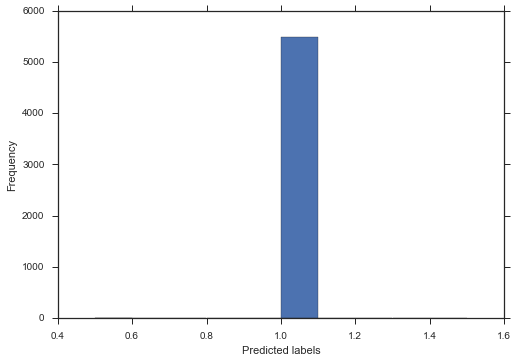

{True}

In [22]:
# look at predictions from model (are they all ones?):
predicted = lr.predict(X_train_std)
plt.hist(predicted)

plt.xlabel('Predicted labels')
plt.ylabel('Frequency')
plt.show()
#predicted.__class__

set(predicted)

# model is outputting all ones...###



### Visualize my features


In [23]:
##### define features:
gamefeatures = ['9_numsuccesses', '9_numunsuccesses',
                '9_gamesize', '9_meandist', '9_successful',
                '9_gamescore', '9_latency', '9_firstdist']
features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons", '9_meanDt']
features = gamefeatures + features
features

['9_numsuccesses',
 '9_numunsuccesses',
 '9_gamesize',
 '9_meandist',
 '9_successful',
 '9_gamescore',
 '9_latency',
 '9_firstdist',
 'game_score',
 'age',
 'game_numFails',
 'phoneInfo',
 'education',
 'gender',
 'phoneUsage',
 'smartphone',
 'hasParkinsons',
 '9_meanDt']

In [24]:
data['smartphone'].unique()

array(['Very easy', 'Neither easy nor difficult', 'Easy', 'Difficult',
       'Very Difficult', nan], dtype=object)

In [25]:
# How many nans in each column?
mt.display_num_nulls_per_column(data)

Number of nulls per column:

recordId                      0
played_game4                  0
hasParkinsons                 0
phoneInfo_demographic         0
appVersion_demographic        0
createdOn_demographic         0
recordId_demographic          0
game_records_txt              0
game_records                  0
gamesdata                     0
game_startDate                0
healthCode                    0
game_numFails                 0
game_numGames                 0
game_score                    0
phoneInfo                     0
appVersion                    0
createdOn                     0
game_endDate                  0
9_gamescore                   2
9_successful                  2
9_meandist                    2
9_gamesize                    2
9_numsuccesses                2
9_numunsuccesses              2
9_firstdist                   2
9_latency                     2
medTimepoint                  4
gender                        5
smartphone                    5
9_meanDt   

### Try Random Forest:

In [270]:
##### define features:

features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]
labelcol = 'hasParkinsons'
features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(data, features, labelcol)       

# create model:
mod = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod.fit(X_train, y_train)

###### assess performance:
mod.fit(X_train, y_train)
print 'training accuracy:', mod.score(X_train, y_train)
print 'test accuracy:', mod.score(X_test, y_test) 
mat = mod.predict_proba(X_test)
#print mat[:,:5]
print mat.__class__
# coveariance?

# WORKS!!!!!!!

Features converted to numbers:

['gender', 'phoneUsage', 'smartphone', 'education', 'phoneInfo']
training accuracy: 0.999452854277
test accuracy: 0.977031050617
<type 'numpy.ndarray'>


#### Assess performance

[[ 462   29]
 [  25 1835]]
1860
1864


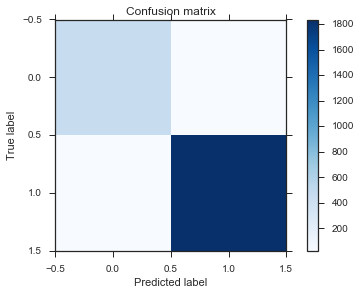

In [271]:
###### get predictions:
y_pred = mod.predict(X_test)
[y_test, y_pred]
sklearn.metrics.roc_auc_score(y_test, y_pred)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print cm
print sum(y_test)
print sum(y_pred)
sum(cm)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
#    tick_marks = np.arange(len(iris.target_names))
#    plt.xticks(tick_marks, iris.target_names, rotation=45)
#    plt.yticks(tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#plot_confusion_matrix(cm_normalized)
plot_confusion_matrix(cm)

In [272]:
# which features matter?
fi = mod.feature_importances_
fi.__class__
S = pd.Series(fi, index=X_names, name="feature importances")
print S.sort_values()



game_numFails    0.013821
phoneUsage       0.024071
gender           0.046499
education        0.062364
game_score       0.064986
phoneInfo        0.068250
smartphone       0.130687
age              0.589321
Name: feature importances, dtype: float64


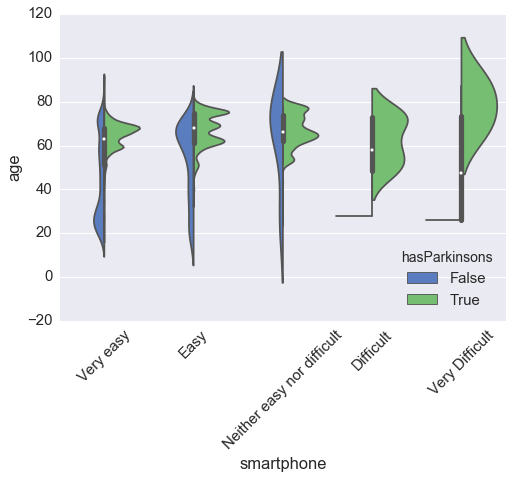

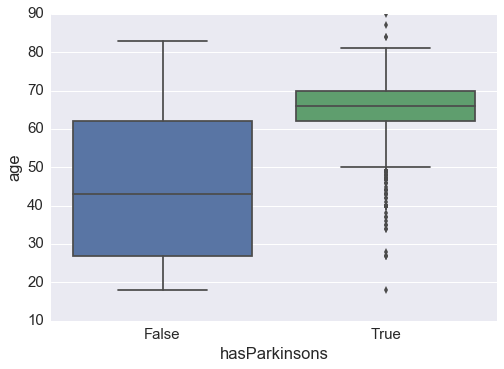

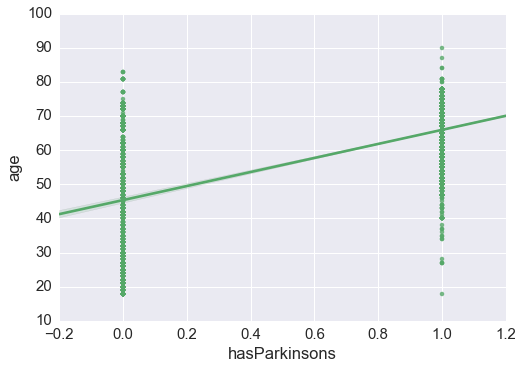

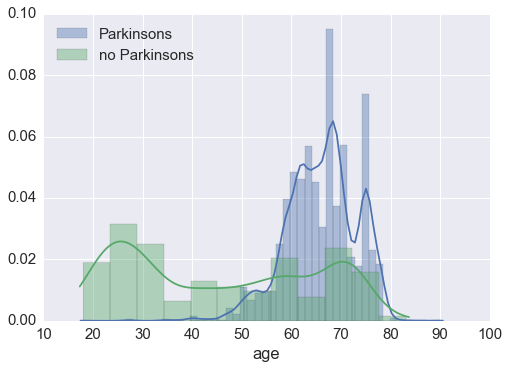

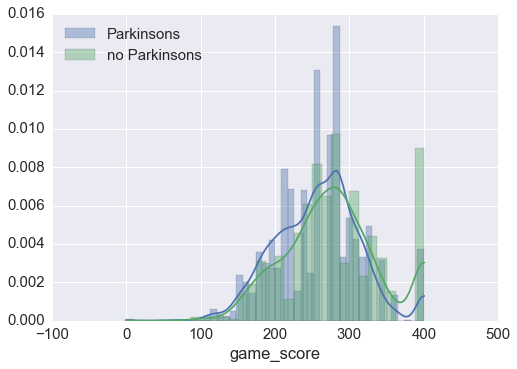

In [305]:

yvar = 'hasParkinsons'
catvar = 'smartphone'#, 'phoneInfo', 'education', 'gender']
freqvar = 'age'#, 'game_score']


order = ['Very easy', 'Easy','Neither easy nor difficult' , 'Difficult','Very Difficult']

#order = 
plt.figure()
ax1 = sns.violinplot(x=catvar, y=freqvar, hue=yvar, data=data, palette="muted", split=True, order=order)    
plt.xticks(rotation=45)


plt.figure()
ax = sns.boxplot(x="hasParkinsons", y="age", data=data)
#plt.figure()
#ax = sns.boxplot(x='hasParkinsons', y='smartphone', data=features_df)
plt.figure()
ax = sns.regplot(x=data['hasParkinsons'], y=data['age'], color="g")

plt.figure()
dp = data[data['hasParkinsons'] == True]
dn = data[data['hasParkinsons'] == False]
sns.distplot(dp['age'].dropna(), label='Parkinsons')
sns.distplot(dn['age'].dropna(), label='no Parkinsons')
plt.legend(loc=2)

sns.set(font_scale=1.5)
plt.figure()
dp = data[data['hasParkinsons'] == True]
dn = data[data['hasParkinsons'] == False]
sns.distplot(dp['game_score'].dropna(), label='Parkinsons')
sns.distplot(dn['game_score'].dropna(), label='no Parkinsons')
plt.legend(loc=2)



In [285]:
# age is a confound - remove it & try again..?
# do simple regression to figure out the parkinsons corrected for age...?


In [31]:
# Do analysis per person 

['game_score', 'age', 'game_numFails', 'phoneInfo', 'education', 'gender', 'phoneUsage', 'smartphone', 'hasParkinsons']
[400, 90.0, 4, 'iPhone 6 Plus', 'Some high school', 'Male', 'true', 'Very easy', True]
400.0


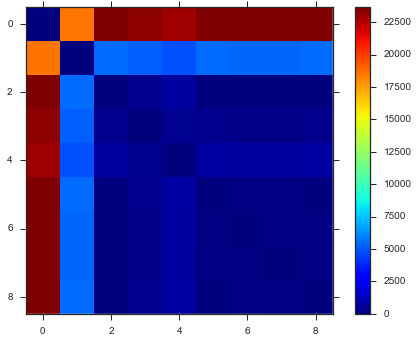

In [32]:
# distance matrix of X matrix (and y-column in there too):
import scipy.spatial.distance as dist
Xy = np.hstack((X, y.reshape(len(y),1)))
dd = dist.pdist(Xy.T, 'euclidean')
dd = dist.squareform(dd)
plt.imshow(dd, interpolation='none', cmap='jet')
plt.colorbar()

print features
print [data[f].max() for f in features]
print Xy.max()


In [33]:
# redo random forest with less features.. (BREAK THE MODEL)
##### define features:

features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]
features.remove('age')
#features.remove('smartphone')
#features.remove('education')
#features.remove('gender')
#features.remove('phoneUsage')
labelcol = 'hasParkinsons'
features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(data, features, labelcol)  

# create model:
mod2 = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod2.fit(X_train, y_train)

###### assess performance:
mod2.fit(X_train, y_train)
print 'training accuracy:', mod2.score(X_train, y_train)
print 'test accuracy:', mod2.score(X_test, y_test) 
mat = mod2.predict_proba(X_test)
#print mat
# which features matter?
fi = mod2.feature_importances_
mod2.feature_importances_

S = pd.Series(fi, index=X_names, name="feature importances")
print S.sort_values()

Features converted to numbers:

['gender', 'phoneUsage', 'smartphone', 'education', 'phoneInfo']
training accuracy: 0.908213440175
test accuracy: 0.8632115548
game_numFails    0.029370
phoneUsage       0.062674
gender           0.080077
phoneInfo        0.118870
education        0.185199
game_score       0.255090
smartphone       0.268719
Name: feature importances, dtype: float64


In [34]:
# redo random forest with less features.. (BREAK THE MODEL)
##### define features:

features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]
features.remove('age')
features.remove('smartphone')
#features.remove('education')
#features.remove('gender')
#features.remove('phoneUsage')
labelcol = 'hasParkinsons'
features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(data, features, labelcol)  

# create model:
mod2 = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod2.fit(X_train, y_train)

###### assess performance:
mod2.fit(X_train, y_train)
print 'training accuracy:', mod2.score(X_train, y_train)
print 'test accuracy:', mod2.score(X_test, y_test) 
mat = mod2.predict_proba(X_test)
#print mat
# which features matter?
fi = mod2.feature_importances_
mod2.feature_importances_

S = pd.Series(fi, index=X_names, name="feature importances")
print S.sort_values()

Features converted to numbers:

['gender', 'phoneUsage', 'education', 'phoneInfo']
training accuracy: 0.85849572027
test accuracy: 0.807561597281
game_numFails    0.049797
phoneUsage       0.076974
gender           0.089943
phoneInfo        0.157352
education        0.258203
game_score       0.367731
Name: feature importances, dtype: float64


[[ 213  259]
 [ 194 1688]]
1882
1947


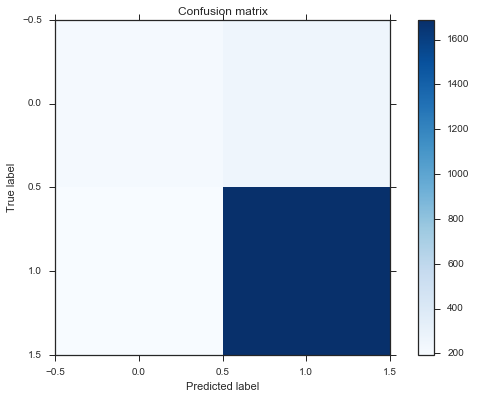

In [35]:
#  Confusion matrix:
#plot WWTF?@!
###### get predictions:
y_pred = mod2.predict(X_test)
[y_test, y_pred]
sklearn.metrics.roc_auc_score(y_test, y_pred)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print cm
print sum(y_test)
print sum(y_pred)
sum(cm)
plot_confusion_matrix(cm)

#monkey


In [36]:
# redo random forest with less features.. (BREAK THE MODEL)
##### define features:
gamefeatures =  ['9_numsuccesses', '9_numunsuccesses',
                '9_gamesize', '9_meandist', '9_successful',
                '9_gamescore', '9_latency', '9_firstdist', '9_meanDt']

features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]
features.remove('age')
features.remove('smartphone')
features = features + gamefeatures
labelcol = 'hasParkinsons'
features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(data, features, labelcol)  

# create model:
mod2 = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod2.fit(X_train, y_train)

###### assess performance:
mod2.fit(X_train, y_train)
print 'training accuracy:', mod2.score(X_train, y_train)
print 'test accuracy:', mod2.score(X_test, y_test) 
mat = mod2.predict_proba(X_test)
#print mat
# which features matter?
fi = mod2.feature_importances_
mod2.feature_importances_

S = pd.Series(fi, index=X_names, name="feature importances")
print S.sort_values()

Features converted to numbers:

['gender', 'phoneUsage', 'education', 'phoneInfo']
training accuracy: 1.0
test accuracy: 0.880952380952
9_gamesize          0.000000
9_successful        0.005806
9_numunsuccesses    0.006454
9_numsuccesses      0.014946
9_gamescore         0.016359
game_numFails       0.021066
phoneUsage          0.025296
gender              0.049122
phoneInfo           0.056090
education           0.075548
game_score          0.075828
9_firstdist         0.108384
9_latency           0.122569
9_meandist          0.124092
9_meanDt            0.298439
Name: feature importances, dtype: float64


In [37]:
# redo random forest with less features.. (BREAK THE MODEL)
##### define features:
features = ['hasParkinsons', '9_latency', '9_meandist', '9_firstdist','game_score','education', '9_meanDt']
labelcol = 'hasParkinsons'
features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(data, features, labelcol)  

# create model:
mod2 = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod2.fit(X_train, y_train)

###### assess performance:
mod2.fit(X_train, y_train)
print 'training accuracy:', mod2.score(X_train, y_train)
print 'test accuracy:', mod2.score(X_test, y_test) 
mat = mod2.predict_proba(X_test)
#print mat
# which features matter?
fi = mod2.feature_importances_
mod2.feature_importances_

S = pd.Series(fi, index=X_names, name="feature importances")
print S.sort_values()

Features converted to numbers:

['education']
training accuracy: 1.0
test accuracy: 0.837585034014
education      0.061976
game_score     0.106769
9_firstdist    0.146806
9_latency      0.156070
9_meandist     0.166370
9_meanDt       0.362009
Name: feature importances, dtype: float64


In [38]:
#

In [39]:
# LOOK AT INDIVIDUALS, TAKING MEDICINE VS NOT.

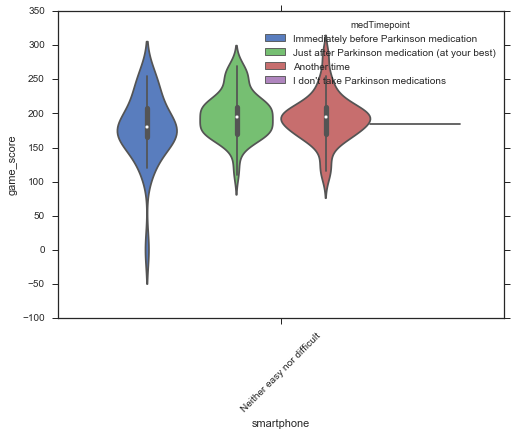

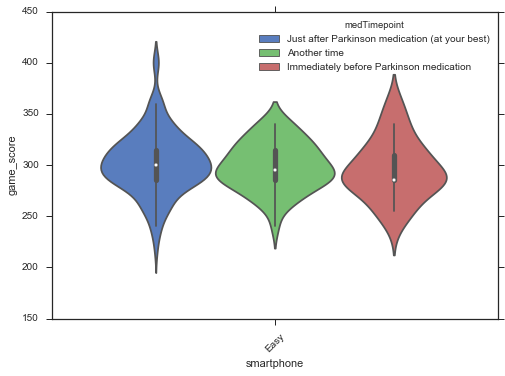

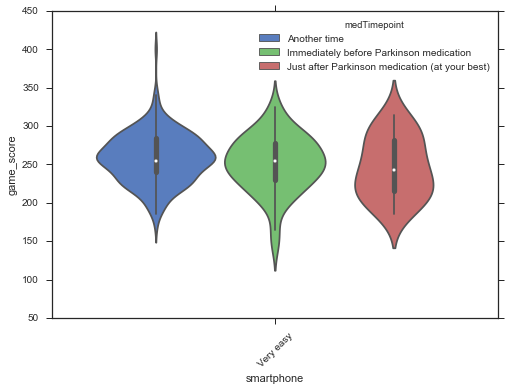

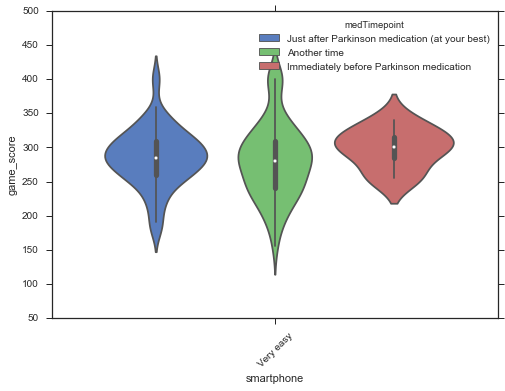

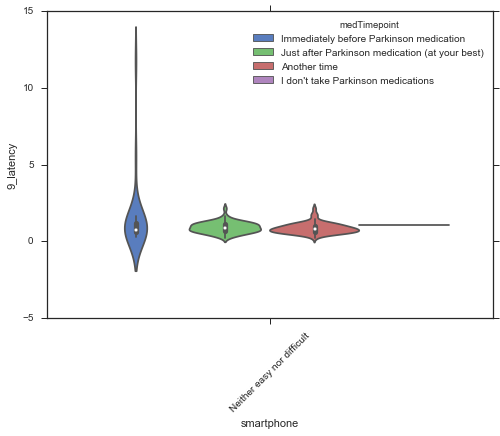

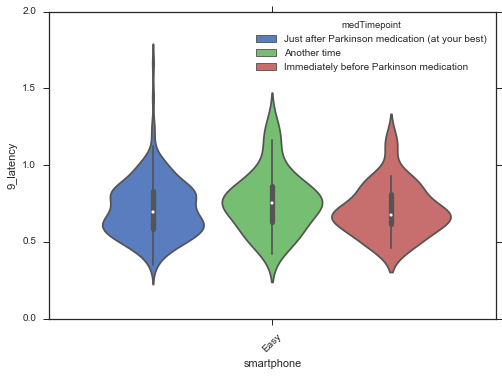

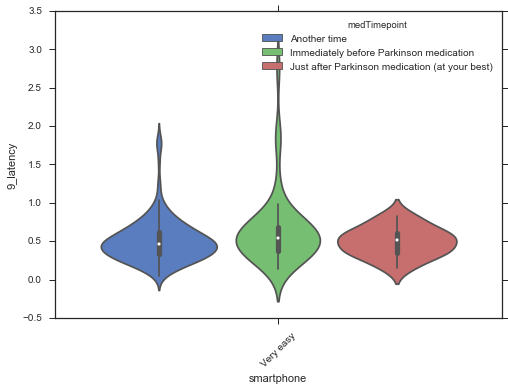

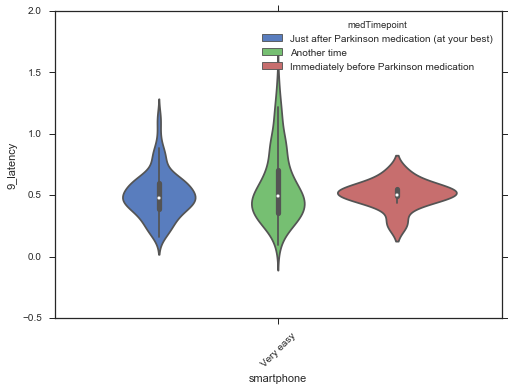

In [40]:
#individuals = data.groupby('healthCode')
individuals = data.loc[data['hasParkinsons']==True].groupby('healthCode')

#yvar = 'hasParkinsons'
#catvars = ['smartphone', 'phoneInfo', 'education', 'gender']
#freqvars = ['age', 'game_score']
yvar = 'medTimepoint'
catvar = 'smartphone'
freqvar = 'game_score'
for id, df in individuals:
    if len(df) > 150:
        plt.figure()
        ax1 = sns.violinplot(x=catvar, y=freqvar, hue=yvar, data=df, palette="muted")#, split=True)    
        plt.xticks(rotation=45)

yvar = 'medTimepoint'
catvar = 'smartphone'
freqvar = '9_latency'
for id, df in individuals:
    if len(df) > 150:
        plt.figure()
        ax1 = sns.violinplot(x=catvar, y=freqvar, hue=yvar, data=df, palette="muted")#, split=True)    
        plt.xticks(rotation=45)



        
        
    

In [41]:
# redo random forest with less features.. (BREAK THE MODEL)
##### define features:
gamefeatures =  ['9_numsuccesses', '9_numunsuccesses',
                '9_gamesize', '9_meandist', '9_successful',
                '9_gamescore', '9_latency', '9_firstdist', '9_meanDt']

features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]

features = gamefeatures + features
features.remove('9_numunsuccesses')
labelcol = 'hasParkinsons'
features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(data, features, labelcol)  

# create model:
mod2 = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod2.fit(X_train, y_train)

###### assess performance:
mod2.fit(X_train, y_train)
print 'training accuracy:', mod2.score(X_train, y_train)
print 'test accuracy:', mod2.score(X_test, y_test) 
mat = mod2.predict_proba(X_test)
#print mat
# which features matter?
fi = mod2.feature_importances_
mod2.feature_importances_

S = pd.Series(fi, index=X_names, name="feature importances")
print S.sort_values()

Features converted to numbers:

['gender', 'phoneUsage', 'smartphone', 'education', 'phoneInfo']
training accuracy: 1.0
test accuracy: 0.96509152831
9_gamesize        0.000000
9_successful      0.003390
9_numsuccesses    0.006896
9_gamescore       0.006900
game_numFails     0.010331
phoneUsage        0.015572
game_score        0.031713
gender            0.032179
education         0.037494
phoneInfo         0.045119
9_firstdist       0.045900
9_meandist        0.053984
9_latency         0.054465
smartphone        0.099133
9_meanDt          0.139722
age               0.417201
Name: feature importances, dtype: float64


['9_numsuccesses', '9_gamesize', '9_meandist', '9_successful', '9_gamescore', '9_latency', '9_firstdist', '9_meanDt', 'game_score', 'age', 'game_numFails', 'phoneInfo', 'education', 'gender', 'phoneUsage', 'smartphone', 'hasParkinsons']
[3.6666666666666665, 9.0, 206.77473014123353, 1.0, 82.5, 11.75321187500958, 204.88106305854623, 2.6244784392341298, 400, 90.0, 4, 'iPhone 6 Plus', 'Some high school', 'Male', 'true', 'Very easy', True]
400.0


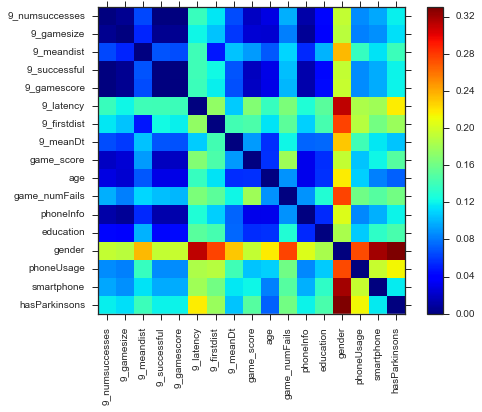

In [42]:
# distance matrix of X matrix (and y-column in there too):
import scipy.spatial.distance as dist


Xy = np.hstack((X, y.reshape(len(y),1)))
dd = dist.pdist(Xy.T, 'cosine')
dd = dist.squareform(dd)
plt.imshow(dd, interpolation='none', cmap='jet')
plt.colorbar()
plt.xticks(rotation=45)
plt.yticks(range(len(features)), features)#, rotation='vertical')
plt.xticks(range(len(features)), features, rotation='vertical')
print features
print [data[f].max() for f in features]
print Xy.max()



In [43]:
# redo random forest with less features.. (BREAK THE MODEL)
##### define features:
gamefeatures =  ['9_numsuccesses', '9_numunsuccesses',
                '9_gamesize', '9_meandist', '9_successful',
                '9_gamescore', '9_latency', '9_firstdist', '9_meanDt',
                '16_numsuccesses', '16_numunsuccesses',
                '16_gamesize', '16_meandist', '16_successful',
                '16_gamescore', '16_latency', '16_firstdist', '16_meanDt']

features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]

features = gamefeatures + features
features.remove('9_numunsuccesses')
features.remove('16_numunsuccesses')
labelcol = 'hasParkinsons'
features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(data, features, labelcol)  
print 'There are now %s samples, after filtering nas' % len(y)

# create model:
mod2 = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod2.fit(X_train, y_train)

###### assess performance:
mod2.fit(X_train, y_train)
print 'training accuracy:', mod2.score(X_train, y_train)
print 'test accuracy:', mod2.score(X_test, y_test) 
mat = mod2.predict_proba(X_test)
#print mat
# which features matter?
fi = mod2.feature_importances_
mod2.feature_importances_

S = pd.Series(fi, index=X_names, name="feature importances")
print S.sort_values()

Features converted to numbers:

['gender', 'phoneUsage', 'smartphone', 'education', 'phoneInfo']
There are now 7551 samples, after filtering nas
training accuracy: 1.0
test accuracy: 0.94880847308
9_gamesize         0.000000
16_gamesize        0.000000
9_successful       0.002266
game_numFails      0.004075
9_gamescore        0.004394
9_numsuccesses     0.004437
16_successful      0.006258
phoneUsage         0.012586
16_numsuccesses    0.016749
16_gamescore       0.019918
game_score         0.020430
gender             0.024704
education          0.026494
9_firstdist        0.026510
16_firstdist       0.031233
phoneInfo          0.034045
16_latency         0.034636
9_latency          0.038348
9_meandist         0.038672
16_meandist        0.038913
smartphone         0.101295
16_meanDt          0.107039
9_meanDt           0.111482
age                0.295517
Name: feature importances, dtype: float64


['9_numsuccesses', '9_gamesize', '9_meandist', '9_successful', '9_gamescore', '9_latency', '9_firstdist', '9_meanDt', '16_numsuccesses', '16_gamesize', '16_meandist', '16_successful', '16_gamescore', '16_latency', '16_firstdist', '16_meanDt', 'game_score', 'age', 'game_numFails', 'phoneInfo', 'education', 'gender', 'phoneUsage', 'smartphone', 'hasParkinsons']
[3.6666666666666665, 9.0, 206.77473014123353, 1.0, 82.5, 11.75321187500958, 204.88106305854623, 2.6244784392341298, 6.0, 16.0, 109.90672012692281, 1.0, 137.5, 16.05716520833084, 303.9111712326482, 6.5116739791628797, 400, 90.0, 4, 'iPhone 6 Plus', 'Some high school', 'Male', 'true', 'Very easy', True]
400.0


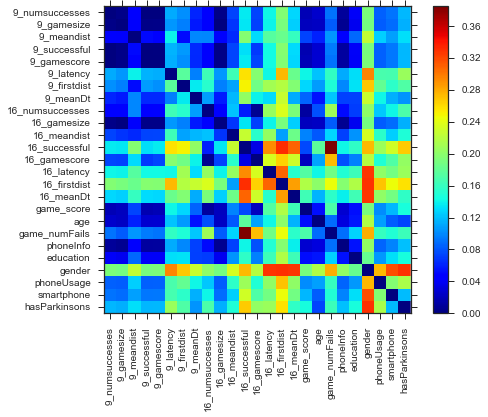

In [44]:
# distance matrix of X matrix (and y-column in there too):
import scipy.spatial.distance as dist


Xy = np.hstack((X, y.reshape(len(y),1)))
dd = dist.pdist(Xy.T, 'cosine')
dd = dist.squareform(dd)
plt.imshow(dd, interpolation='none', cmap='jet')
plt.colorbar()
plt.xticks(rotation=45)
plt.yticks(range(len(features)), features)#, rotation='vertical')
plt.xticks(range(len(features)), features, rotation='vertical')
print features
print [data[f].max() for f in features]

print Xy.max()

Features converted to numbers:

[]


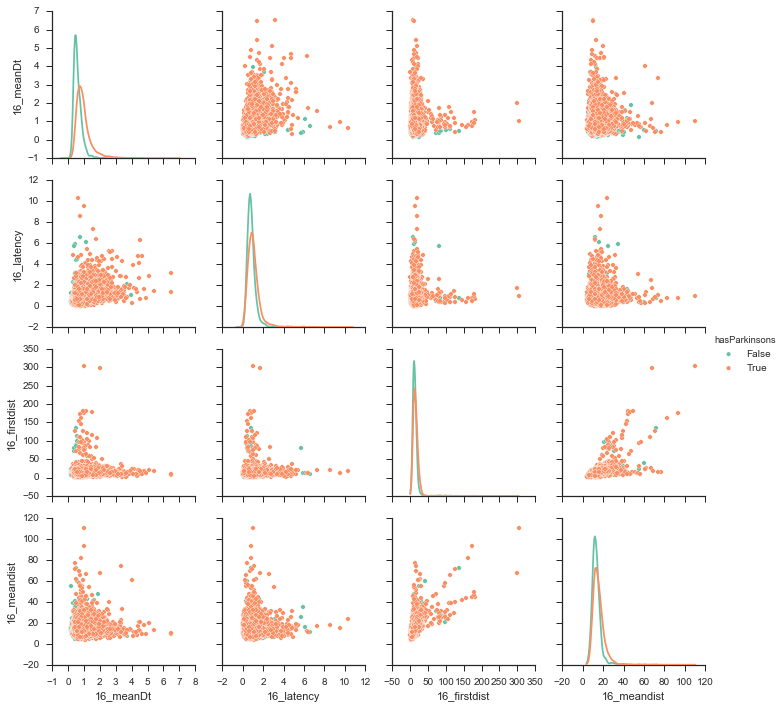

In [45]:
#featurestoPlot = ["age", "game_score", '9_gamescore', '9_latency', '9_meanDt', '9_firstdist', '9_meandist']
#features_df = data[["game_score",'16_gamescore','hasParkinsons']]
features_df = data[['16_meanDt','16_latency', '16_firstdist', '16_meandist', 'hasParkinsons']]
plotfeatures = ['16_meanDt','16_latency', '16_firstdist', '16_meandist']
features_df = mt.convert_features_to_numbers(features_df).dropna()
g = sns.pairplot(features_df, x_vars=plotfeatures,y_vars=plotfeatures,hue="hasParkinsons", palette="Set2", diag_kind="kde", markers="o")#, size=2.5)




SyntaxError: 'return' outside function (<ipython-input-46-8cf9cc0a5b62>, line 4)

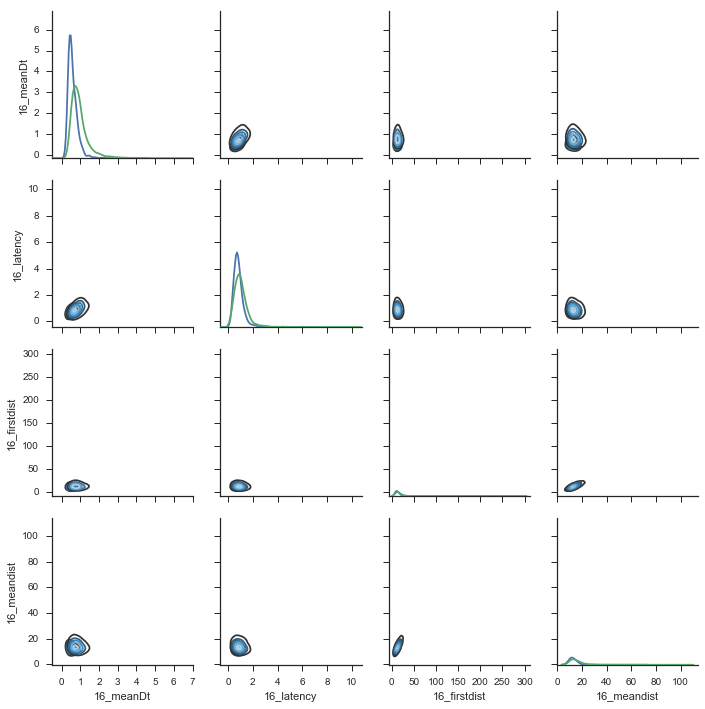

In [46]:
g = sns.PairGrid(features_df,x_vars=plotfeatures,y_vars=plotfeatures,hue="hasParkinsons")
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6)
return g

Features converted to numbers:

[]


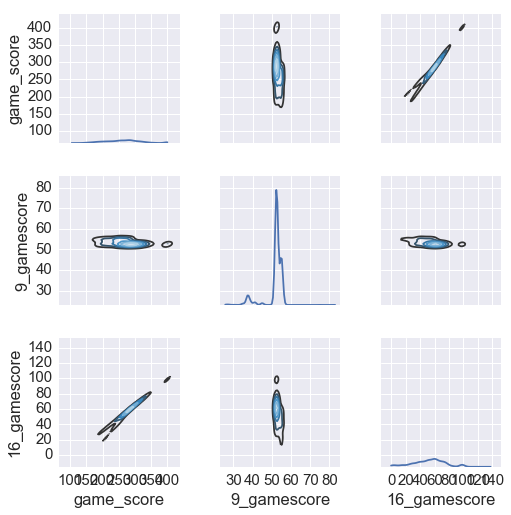

In [314]:
#featurestoPlot = ["age", "game_score", '9_gamescore', '9_latency', '9_meanDt', '9_firstdist', '9_meandist']
features_df = data[["game_score", '9_gamescore', '16_gamescore']]
features_df = mt.convert_features_to_numbers(features_df).dropna()
g = mt.squaregridhistplot(features_df)



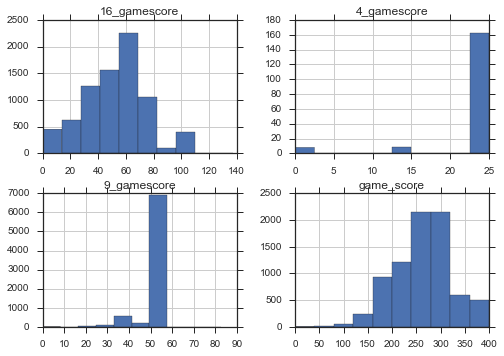

In [49]:
features_df = data[['4_gamescore', '9_gamescore', '16_gamescore', "game_score" ]]
features_df.hist()
pass

Features converted to numbers:

[]


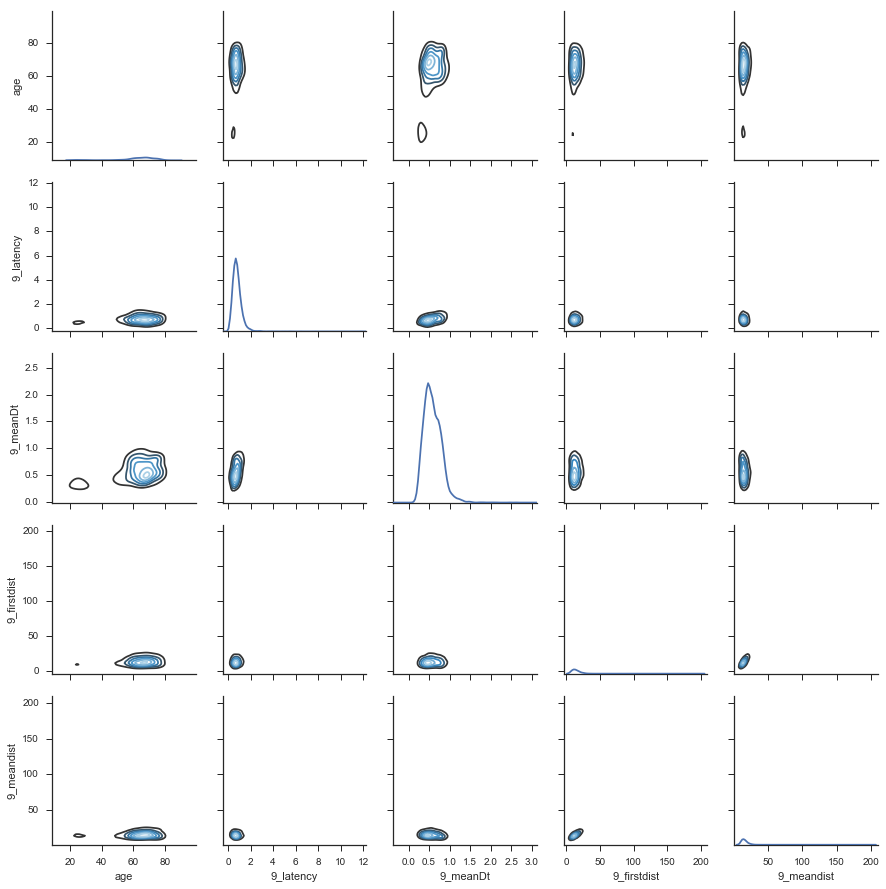

In [51]:
#featurestoPlot = ["age", "game_score", '9_gamescore', '9_latency', '9_meanDt', '9_firstdist', '9_meandist']
featurestoPlot = ["age", '9_latency', '9_meanDt', '9_firstdist', '9_meandist']
features_df = data[featurestoPlot]
features_df = mt.convert_features_to_numbers(features_df).dropna()
g = mt.squaregridhistplot(features_df)
pass

In [315]:
# redo random forest with all game features.. 

##### define features:
demographicfeatures = ['gender','education','employment']
gamefeatures = [
    'game_numFails',
    'game_score',
    'game_numGames',
    '9_numsuccesses',
    '9_numunsuccesses',
    '9_meandist',
    '9_successful',
    '9_gamescore',
    '9_latency',
    '9_firstdist',
    '9_meanDt',
    '9_meansuccessfuldist',
    '16_firstdist',
    '16_meandist',
    '16_numsuccesses',
    '16_gamescore',
    '16_latency',
    '16_numunsuccesses',
    '16_successful',
    '16_meanDt',
    '16_meansuccessfuldist',
    '16_meanunsuccessfuldist']
confoundfeatures = ['smartphone','age']

features = gamefeatures
features.append('hasParkinsons')

labelcol = 'hasParkinsons'
features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(data, features, labelcol)  

# create model:
mod = RandomForestClassifier(n_estimators=100)
mod.fit(X_train, y_train)

###### assess performance:
mod.fit(X_train, y_train)
print 'training accuracy:', mod.score(X_train, y_train)
print 'test accuracy:', mod.score(X_test, y_test) 
mat = mod.predict_proba(X_test)
#print mat
# which features matter?
fi = mod.feature_importances_
mod.feature_importances_

S = pd.Series(fi, index=X_names, name="feature importances")
print S.sort_values()

Features converted to numbers:

[]
training accuracy: 1.0
test accuracy: 0.849282296651
game_numGames              0.000277
9_numunsuccesses           0.002454
9_successful               0.002545
game_numFails              0.003790
9_numsuccesses             0.006102
9_gamescore                0.006682
16_numunsuccesses          0.008838
16_successful              0.009131
16_numsuccesses            0.025717
game_score                 0.029889
16_gamescore               0.030572
9_meansuccessfuldist       0.052723
16_meanunsuccessfuldist    0.053006
9_firstdist                0.054405
9_meandist                 0.055107
16_firstdist               0.055175
16_latency                 0.060625
16_meansuccessfuldist      0.062690
16_meandist                0.064792
9_latency                  0.069675
16_meanDt                  0.158114
9_meanDt                   0.187691
Name: feature importances, dtype: float64


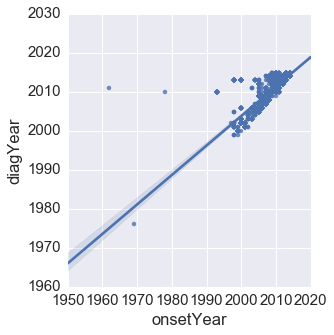

In [317]:
# correlation of onset year and diagnosis year
x='onsetYear'
y='diagYear'
d = data[[x, y]].dropna()
#sns.jointplot(x="onsetYear", y="diagYear", data=d, kind="kde")

lm = sns.lmplot(x,y,d)
#axes = lm.axes
#axes[0,0].set_ylim(1990,)

### Explore feature relationships:

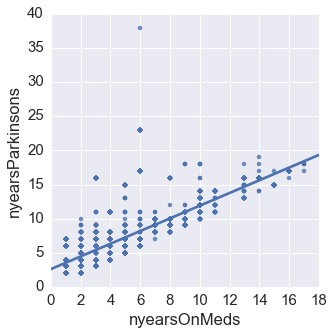

In [318]:
from numpy import nan
# correlation of medication start year versus years parkinsons
x='nyearsOnMeds'
y='nyearsParkinsons'
df = data[[x, y]].dropna()
lm = sns.lmplot(x,y,df)

In [319]:
# load feature categories
fcats = mt.define_feature_categories()
fcats

Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds


{'demographic': ['age', 'gender', 'education'],
 'game': ['game_numFails',
  'game_score',
  'game_numGames',
  '9_numsuccesses',
  '9_numunsuccesses',
  '9_meandist',
  '9_successful',
  '9_gamescore',
  '9_latency',
  '9_firstdist',
  '9_meanDt',
  '9_meansuccessfuldist',
  '16_firstdist',
  '16_meandist',
  '16_numsuccesses',
  '16_gamescore',
  '16_latency',
  '16_numunsuccesses',
  '16_successful',
  '16_meanDt',
  '16_meansuccessfuldist',
  'played_game4'],
 'output': ['hasParkinsons',
  'medTimepoint',
  'brainStim',
  'surgery',
  'nyearsOnMeds',
  'nyearsOffMeds',
  'nyearsParkinsons'],
 'person': ['healthCode'],
 'phone': ['phoneInfo', 'smartphone'],
 'time': ['game_endDate', 'createdOn', 'game_startDate']}

In [320]:
# do an all vs. has parkinsons ttest:
features = fcats['game'] + fcats['demographic'] + fcats['output']
features.remove('medTimepoint')
features_df = data[features]
features_df = mt.convert_features_to_numbers(features_df)
features_df.head(2)

ttestresults = mt.column_ttests(features_df, 'hasParkinsons')
ttestresults



Features converted to numbers:

['gender', 'education']


,pvals,tstats
age,0.000000e+00,-69.068114
9_meanDt,9.147164e-284,-37.537540
16_meanDt,4.482584e-168,-28.345833
16_meansuccessfuldist,9.593696e-69,-17.702716
gender,2.646628e-55,15.788229
9_meansuccessfuldist,9.954155e-48,-14.611920
16_meandist,2.509532e-44,-14.055256
brainStim,6.543204e-40,-13.298607
9_meandist,4.565962e-37,-12.786456
9_firstdist,7.677056e-37,-12.745159


In [321]:
# obviously, age is a huge confound. gender is too?!

### Redo machine learning after dealing with age confound:

#### Resample non-parkinsons to same age distribution as Parkinsons:

RanksumsResult(statistic=-1.4969933378191751, pvalue=0.134394991578794)


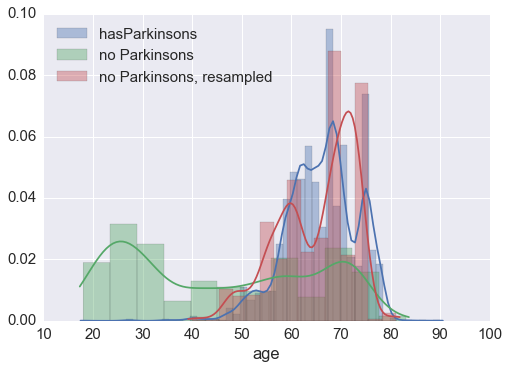

In [322]:
# resample non-Park to same age distribution as Parkinsons:
df = features_df
distcol = 'age'
splitcol = 'hasParkinsons'
splitVal_resample = False
splitVal_guide = True
nbins = 10
nResamples = 600
df_resampled, df_guide, df_resample = mt.resample_to_match_distribution(df, distcol, splitcol, splitVal_resample, splitVal_guide, nbins, nResamples)
df_resampled_np = df_resampled
df_Parkinsons = df_guide
df_np = df_resample

sns.distplot(df_guide[distcol].dropna(), label='hasParkinsons')
sns.distplot(df_resample[distcol].dropna(), label='no Parkinsons')
sns.distplot(df_resampled[distcol].dropna(), label='no Parkinsons, resampled')
plt.legend(loc=2)

x = df_resampled[distcol].dropna().values
y = df_guide[distcol].dropna().values
p2 = ranksums(x, y)
print p2




RanksumsResult(statistic=-2.6209914809714676, pvalue=0.008767445280575728)


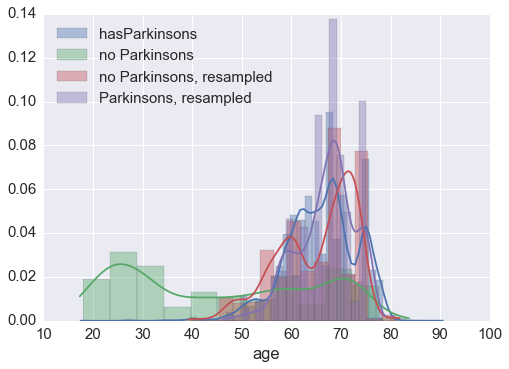

In [323]:
# resample Park to the resampled non-Park for sample balancing:
# resample non-Park to same age distribution as Parkinsons:
df = df_resampled_np.append(df_Parkinsons)
distcol = 'age'
splitcol = 'hasParkinsons'
splitVal_resample = True
splitVal_guide = False
df_resampled, df_guide, df_resample = mt.resample_to_match_distribution(df, distcol, splitcol, splitVal_resample, splitVal_guide, nbins, nResamples)
df_resampled_Park = df_resampled


sns.distplot(df_Parkinsons[distcol].dropna(), label='hasParkinsons')
sns.distplot(df_np[distcol].dropna(), label='no Parkinsons')
sns.distplot(df_resampled_np[distcol].dropna(), label='no Parkinsons, resampled')
sns.distplot(df_resampled_Park[distcol].dropna(), label='Parkinsons, resampled')
plt.legend(loc=2)

x = df_resampled_np[distcol].dropna().values
y = df_resampled_Park[distcol].dropna().values
p2 = ranksums(x, y)
print p2


In [308]:
### Redo machine learning with these sets:
df = df_resampled_np.append(df_resampled_Park)
features = fcats['game'] + ['hasParkinsons']# + fcats['demographic'] + fcats['output']
#features = ['9_firstdist', '9_meansuccessfuldist', '16_meansuccessfuldist', '9_latency', '16_meanDt', '9_meanDt', 'hasParkinsons']
#features = [ '16_meansuccessfuldist', '9_latency', '16_meanDt', '9_meanDt', 'hasParkinsons']

labelcol = 'hasParkinsons'
#mt.display_num_nulls_per_column(df[features])

features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(df, features, labelcol, convert_features_to_nums=False)       


# create model:
mod = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod.fit(X_train, y_train)

###### assess performance:
mod.fit(X_train, y_train)
print 'training accuracy:', mod.score(X_train, y_train)
print 'test accuracy:', mod.score(X_test, y_test) 
print 'num actual positives = %s' % sum(y)
print 'num actual negatives = %s' % (len(y) - sum(y))
print 'random accuracy would be %s' % (float(sum(y))/len(y))
print '\n'

# which features matter?
#print mat
mat = mod.predict_proba(X_test)

print 'feature importances:'
S = pd.Series(mod.feature_importances_, index=X_names, name="feature importances")
print S.sort_values()


#  Confusion matrix:
y_pred = mod.predict(X_test)
sklearn.metrics.roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print cm
plot_confusion_matrix(cm)


KeyError: "['game_numGames' '9_numsuccesses' '9_numunsuccesses' '9_meandist'\n '9_successful' '9_gamescore' '9_latency' '9_firstdist' '9_meanDt'\n '9_meansuccessfuldist' '16_firstdist' '16_meandist' '16_numsuccesses'\n '16_gamescore' '16_latency' '16_numunsuccesses' '16_successful'\n '16_meanDt' '16_meansuccessfuldist' 'played_game4'] not in index"

In [ ]:
# visualize this new dataset (resampled):

#featurestoPlot = ["age", "game_score", '9_gamescore', '9_latency', '9_meanDt', '9_firstdist', '9_meandist']
#features_df = data[["game_score",'16_gamescore','hasParkinsons']]
fplot = features_df[['16_meanDt','16_latency', '16_firstdist', '16_meandist', 'hasParkinsons']]
plotfeatures = ['16_meanDt','16_latency', '16_firstdist', '16_meandist']
#fplot = fplot.dropna()
g = sns.pairplot(fplot, x_vars=plotfeatures,y_vars=plotfeatures,hue="hasParkinsons", palette="Set2", diag_kind="kde", markers="o")#, size=2.5)



In [ ]:
# To Do:

In [ ]:
# try logistic regression, with l1 (lasso) (minimize # features)

In [ ]:
# do pca of outputs, and see if we can be more predictive

In [ ]:
# split data by person and check on drugs vs not on drugs (what is predictive)

In [ ]:
# time series analysis of indiv. patients, looking at the yes and no data?

In [ ]:
# symptom variance individual patients plot?

In [ ]:
# run rand forest with all in-game features & sample balancing but not correction for age
